In [1]:
import pathlib
import pandas as pd
import numpy as np
import warnings

from copairs.map import aggregate
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

In [2]:
# Directories
processed_data_dir = pathlib.Path("../data/processed/")
mAP_scores_dir = (processed_data_dir / "mAP_scores").resolve(strict=True)
agg_mAP_scores_dir = (processed_data_dir / "aggregate_mAPs").resolve(strict=True)

## Preparing the dataset 
Next seed of the block, we load the collected mAP single-cell scores generated from the previous notebook.
These scores are loaded into a dataframe and separated based on the type of features (CP DP CP_DP).

We further divide the feature space based on the type of shuffling methods applied to it.
Then, we calculate their aggregated average scores using the `copairs` aggregate function.


In [3]:
all_files = list(mAP_scores_dir.glob("*.csv"))

cp_sc_mAPs = []
dp_sc_mAPs = []
cp_dp_sc_mAPs = []
for _file in all_files:
    if _file.name.startswith("cp_dp"):
        cp_dp_sc_mAPs.append(pd.read_csv(_file))
    elif _file.name.startswith("cp_"):
        dp_sc_mAPs.append(pd.read_csv(_file))
    elif _file.name.startswith("dp_"):
        cp_sc_mAPs.append(pd.read_csv(_file))

# single-cell mAP scores
cp_sc_mAPs = pd.concat(cp_sc_mAPs)
dp_sc_mAPs = pd.concat(dp_sc_mAPs)
cp_dp_sc_mAPs = pd.concat(cp_dp_sc_mAPs)

In [4]:
# Separating data frames: One by feature type (CP, DP, CP_DP)
# Additional split is performed using a shuffling approach:
# - feature_shuffled: feature values within the feature space are shuffled.
# - phenotype_shuffled: phenotypic labels are shuffled.
reg_cp_sc_mAPs = cp_sc_mAPs.loc[cp_sc_mAPs["shuffled"] == "non-shuffled"]
reg_cp_sc_mAPs["feature_type"] = "CP"
shuffled_feat_cp_sc_mAPs = cp_sc_mAPs.loc[cp_sc_mAPs["shuffled"] == "features_shuffled"]
shuffled_feat_cp_sc_mAPs["feature_type"] = "CP"
shuffled_pheno_cp_sc_mAPs = cp_sc_mAPs.loc[cp_sc_mAPs["shuffled"] == "phenotype_shuffled"]
shuffled_pheno_cp_sc_mAPs["feature_type"] = "CP"

reg_dp_sc_mAPs = dp_sc_mAPs.loc[dp_sc_mAPs["shuffled"] == "non-shuffled"]
reg_dp_sc_mAPs["feature_type"] = "DP"
shuffled_feat_dp_sc_mAPs = dp_sc_mAPs.loc[dp_sc_mAPs["shuffled"] == "features_shuffled"]
shuffled_feat_dp_sc_mAPs["feature_type"] = "DP"
shuffled_pheno_dp_sc_mAPs = dp_sc_mAPs.loc[dp_sc_mAPs["shuffled"] == "phenotype_shuffled"]
shuffled_pheno_dp_sc_mAPs["feature_type"] = "DP"

reg_cp_dp_sc_mAPs = cp_dp_sc_mAPs.loc[cp_dp_sc_mAPs["shuffled"] == "non-shuffled"]
reg_cp_dp_sc_mAPs["feature_type"] = "CP_DP"
shuffled_feat_cp_dp_sc_mAPs = cp_dp_sc_mAPs.loc[cp_dp_sc_mAPs["shuffled"] == "features_shuffled"]
shuffled_feat_cp_dp_sc_mAPs["feature_type"] = "CP_DP"
shuffled_pheno_cp_dp_sc_mAPs = cp_dp_sc_mAPs.loc[cp_dp_sc_mAPs["shuffled"] == "phenotype_shuffled"]
shuffled_pheno_cp_dp_sc_mAPs["feature_type"] = "CP_DP"

In [5]:
# Generating sampling_error df
# This table will be used to merge with the aggregate table to get the sampling error a specific category.
df_group = pd.concat(
    [
        reg_cp_sc_mAPs,
        reg_dp_sc_mAPs,
        shuffled_feat_cp_sc_mAPs,
        shuffled_pheno_cp_sc_mAPs,
        reg_dp_sc_mAPs,
        shuffled_feat_dp_sc_mAPs,
        shuffled_pheno_dp_sc_mAPs,
        reg_cp_dp_sc_mAPs,
        shuffled_feat_cp_dp_sc_mAPs,
        shuffled_pheno_cp_dp_sc_mAPs,
    ]
).groupby(by=["Mitocheck_Phenotypic_Class", "feature_type", "shuffled"])

sampling_error_df = []
for name, df in df_group:
    pheno, feature_type, shuffled_type = name

    # caclulating sampling error
    avg_percision = df["average_precision"].values
    sampling_error = np.std(avg_percision) / np.sqrt(len(avg_percision))

    sampling_error_df.append([pheno, feature_type, shuffled_type, sampling_error])
cols =["Mitocheck_Phenotypic_Class", "feature_type", "shuffled", "sampling_error"]
sampling_error_df = pd.DataFrame(sampling_error_df, columns=cols)
sampling_error_df

# updating name:
sampling_error_df.loc[sampling_error_df["shuffled"] == "phenotype_shuffled"] = "phenotypes_shuffled"

In [6]:
# Generating aggregate scores with a threshold p-value of 0.05

# feature type: DP
agg_reg_cp_sc_mAPs = aggregate(reg_cp_sc_mAPs, sameby=["Mitocheck_Phenotypic_Class"], threshold=0.05)
agg_reg_cp_sc_mAPs["shuffled"] = "non-shuffled"
agg_reg_cp_sc_mAPs["feature_type"] = "CP"

agg_shuffled_feat_cp_sc_mAPs = aggregate(shuffled_feat_cp_sc_mAPs, sameby=["Mitocheck_Phenotypic_Class"], threshold=0.05)
agg_shuffled_feat_cp_sc_mAPs["shuffled"] = "features_shuffled"
agg_shuffled_feat_cp_sc_mAPs["feature_type"] = "CP"

agg_shuffled_pheno_cp_sc_mAPs = aggregate(shuffled_pheno_cp_sc_mAPs, sameby=["Mitocheck_Phenotypic_Class"], threshold=0.05)
agg_shuffled_pheno_cp_sc_mAPs["shuffled"] = "phenotypes_shuffled"
agg_shuffled_pheno_cp_sc_mAPs["feature_type"] = "CP"

# feature type: DP
agg_reg_dp_sc_mAPs = aggregate(reg_dp_sc_mAPs, sameby=["Mitocheck_Phenotypic_Class"], threshold=0.05)
agg_reg_dp_sc_mAPs["shuffled"] = "non-shuffled"
agg_reg_dp_sc_mAPs["feature_type"] = "DP"

agg_shuffled_feat_dp_sc_mAPs = aggregate(shuffled_feat_dp_sc_mAPs, sameby=["Mitocheck_Phenotypic_Class"], threshold=0.05)
agg_shuffled_feat_dp_sc_mAPs["shuffled"] = "features_shuffled"
agg_shuffled_feat_dp_sc_mAPs["feature_type"] = "DP"

agg_shuffled_pheno_dp_sc_mAPs = aggregate(shuffled_pheno_dp_sc_mAPs, sameby=["Mitocheck_Phenotypic_Class"], threshold=0.05)
agg_shuffled_pheno_dp_sc_mAPs["shuffled"] = "phenotypes_shuffled"
agg_shuffled_pheno_dp_sc_mAPs["feature_type"] = "DP"

# feature type: CP_DP
agg_reg_cp_dp_sc_mAPs = aggregate(reg_cp_dp_sc_mAPs, sameby=["Mitocheck_Phenotypic_Class"], threshold=0.05)
agg_reg_cp_dp_sc_mAPs["shuffled"] = "non-shuffled"
agg_reg_cp_dp_sc_mAPs["feature_type"] = "CP_DP"

agg_shuffled_feat_cp_dp_sc_mAPs = aggregate(shuffled_feat_cp_dp_sc_mAPs, sameby=["Mitocheck_Phenotypic_Class"], threshold=0.05)
agg_shuffled_feat_cp_dp_sc_mAPs["shuffled"] = "features_shuffled"
agg_shuffled_feat_cp_dp_sc_mAPs["feature_type"] = "CP_DP"

agg_shuffled_pheno_cp_dp_sc_mAPs = aggregate(shuffled_pheno_cp_dp_sc_mAPs, sameby=["Mitocheck_Phenotypic_Class"], threshold=0.05)
agg_shuffled_pheno_cp_dp_sc_mAPs["shuffled"] = "phenotypes_shuffled"
agg_shuffled_pheno_cp_dp_sc_mAPs["feature_type"] = "CP_DP"

In [7]:
# saving aggregated scores into the folder
save_dir = mAP_scores_dir / "aggregated_mAPs"

agg_reg_cp_sc_mAPs.to_csv(agg_mAP_scores_dir / "agg_reg_cp_sc_mAPs.csv", index=False)
agg_shuffled_feat_cp_sc_mAPs.to_csv(agg_mAP_scores_dir / "agg_shuffled_feat_cp_sc_mAPs.csv", index=False)
agg_shuffled_pheno_cp_sc_mAPs.to_csv(agg_mAP_scores_dir / "agg_shuffled_pheno_cp_sc_mAPs.csv", index=False)

agg_reg_dp_sc_mAPs.to_csv(agg_mAP_scores_dir / "agg_reg_dp_sc_mAPs.csv", index=False)
agg_shuffled_feat_dp_sc_mAPs.to_csv(agg_mAP_scores_dir / "agg_shuffled_feat_dp_sc_mAPs.csv", index=False)
agg_shuffled_pheno_dp_sc_mAPs.to_csv(agg_mAP_scores_dir / "agg_shuffled_pheno_dp_sc_mAPs.csv", index=False)

agg_reg_cp_dp_sc_mAPs.to_csv(agg_mAP_scores_dir / "agg_reg_cp_dp_sc_mAPs.csv", index=False)
agg_shuffled_feat_cp_dp_sc_mAPs.to_csv(agg_mAP_scores_dir / "agg_shuffled_feat_cp_dp_sc_mAPs.csv", index=False)
agg_shuffled_pheno_cp_dp_sc_mAPs.to_csv(agg_mAP_scores_dir / "agg_shuffled_pheno_cp_dp_sc_mAPs.csv", index=False)

## Forming bar plots 

### Forming bar plots with CP Features

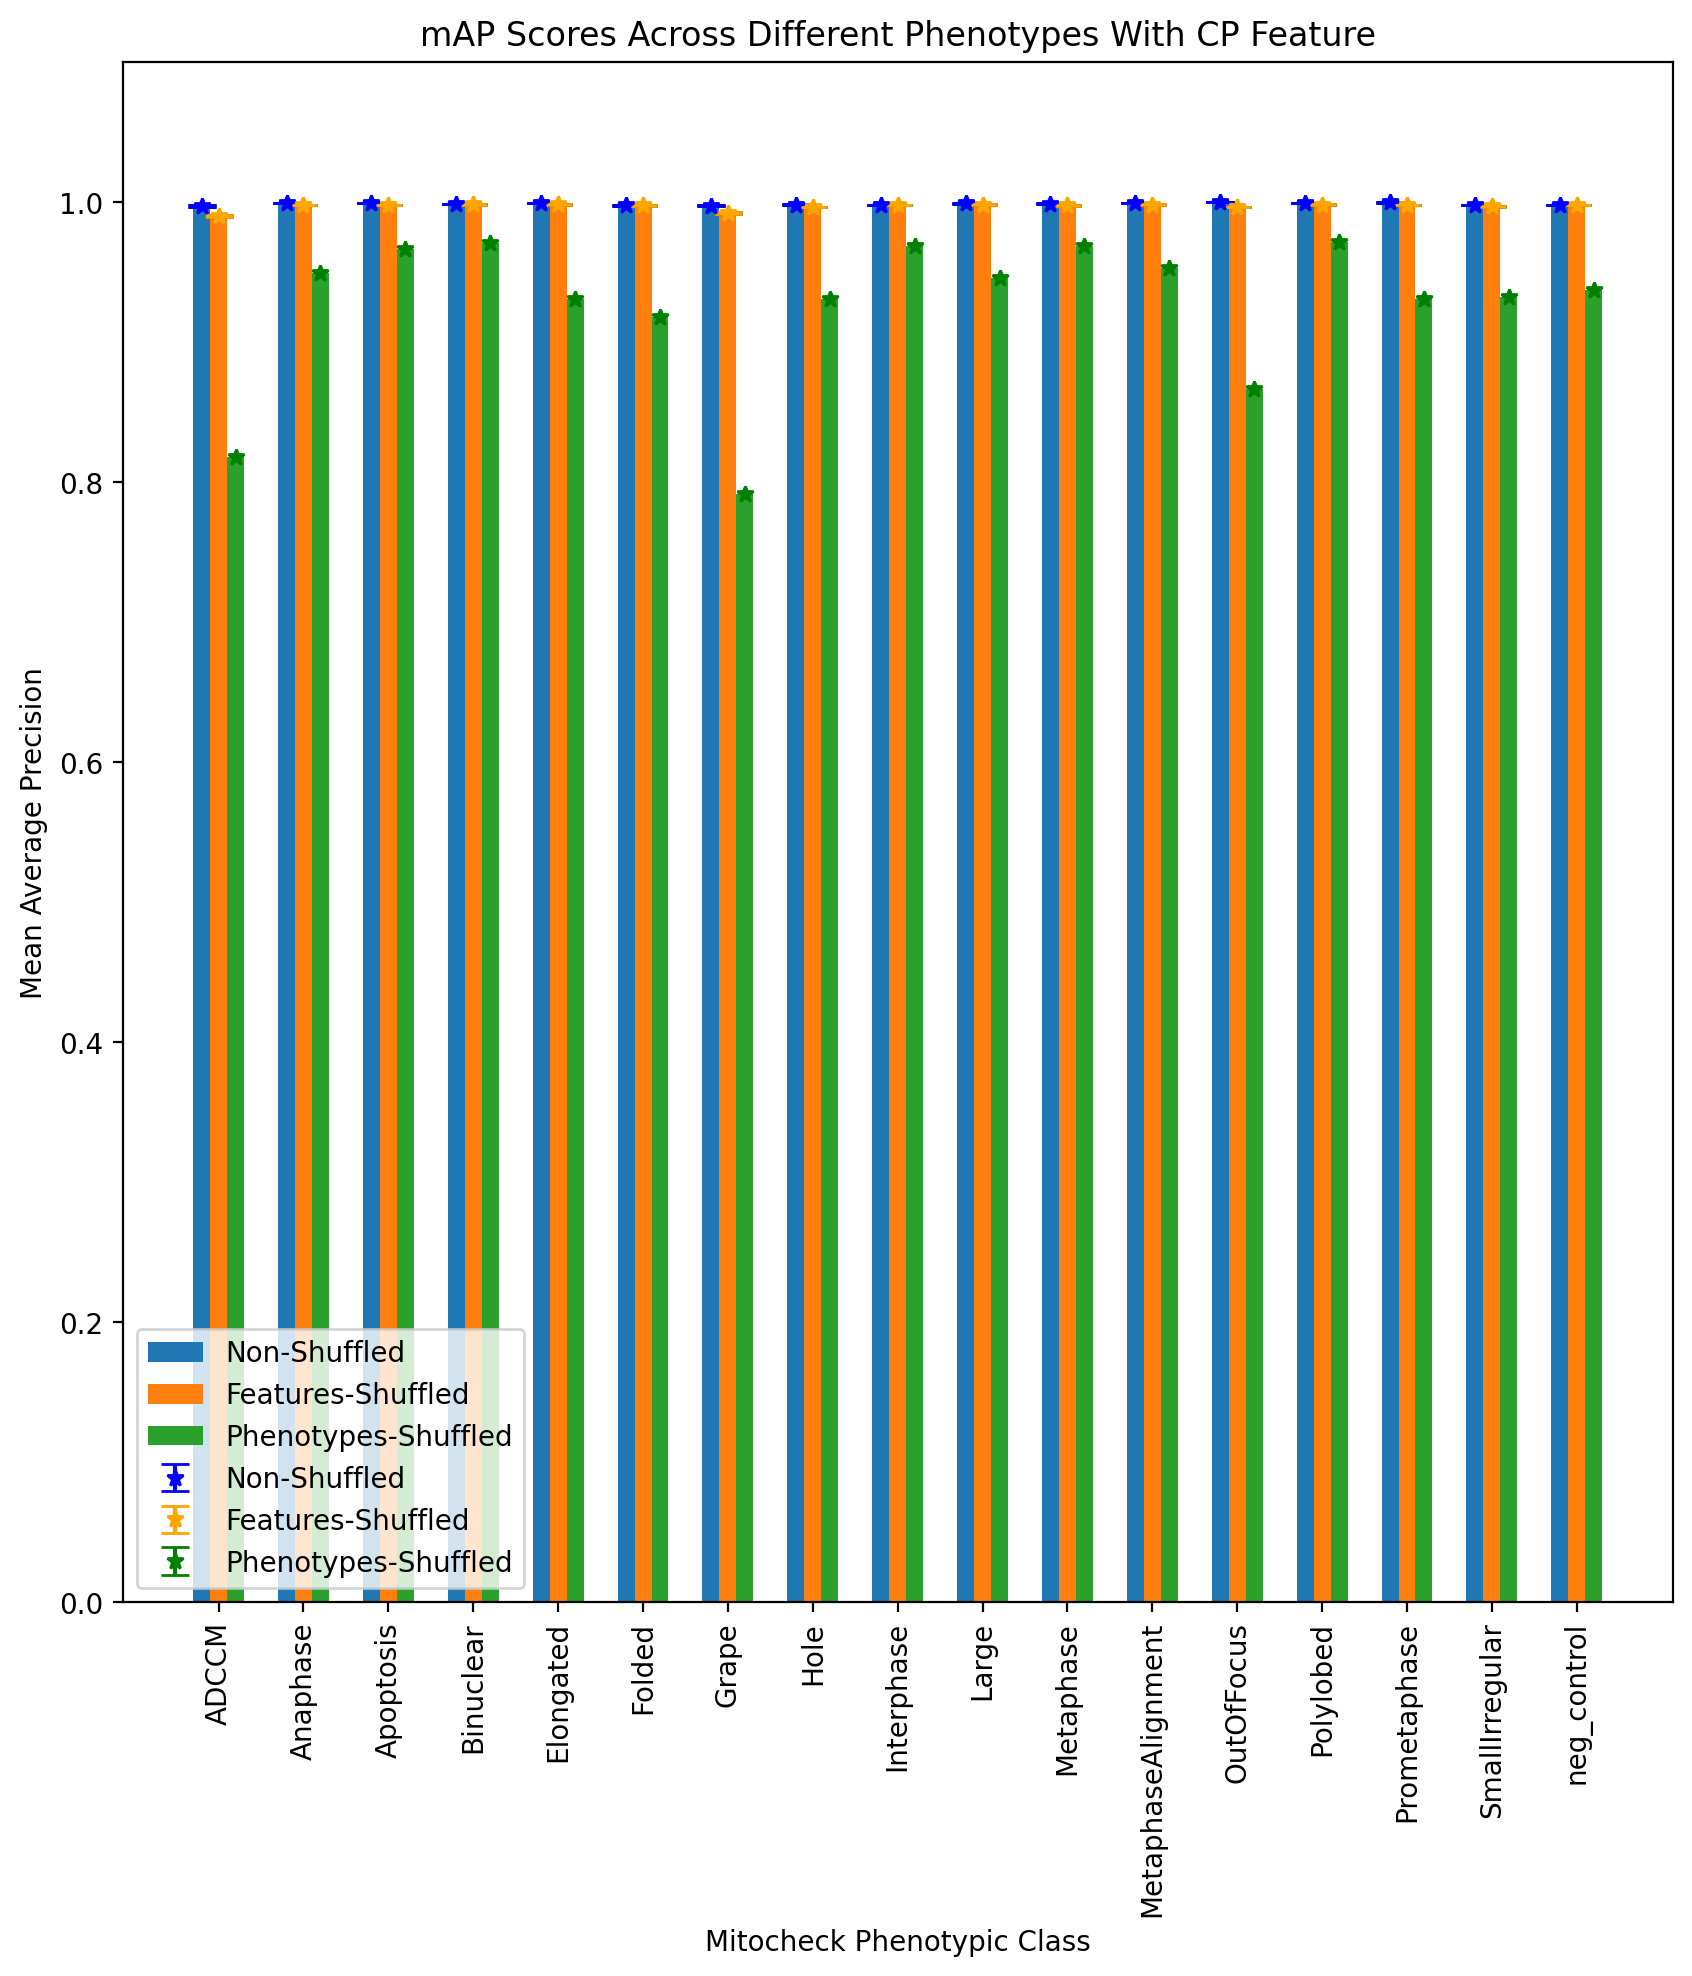

In [8]:
# figure size
plt.figure(figsize=(10, 10), dpi=200)

# phenotypes
data = (
    pd.concat(
        [
            agg_reg_cp_sc_mAPs,
            agg_shuffled_feat_cp_sc_mAPs,
            agg_shuffled_pheno_cp_sc_mAPs,
        ]
    )
    .reset_index()
    .drop("index", axis=1)
    .merge(
        sampling_error_df,
        on=["Mitocheck_Phenotypic_Class", "feature_type", "shuffled"],
        how="left",
    )
)

# creating bar plot
# groups: phenotype
# y-axis = mAP
df = data[
    [
        "Mitocheck_Phenotypic_Class",
        "mean_average_precision",
        "shuffled",
        "sampling_error",
    ]
]

# Pivot the DataFrame to have shuffled as columns
pivot_df = df.pivot_table(
    index="Mitocheck_Phenotypic_Class",
    columns="shuffled",
    values="mean_average_precision",
)

# Width of each bar
bar_width = 0.2

# Set positions for each group
positions = np.arange(len(pivot_df))

# Plot bars for each group
plt.bar(
    positions - bar_width,
    pivot_df["non-shuffled"],
    yerr=data[data["shuffled"] == "non-shuffled"]["sampling_error"],
    capsize=5,
    width=bar_width,
    label="Non-Shuffled",
)
plt.bar(
    positions,
    pivot_df["features_shuffled"],
    yerr=data[data["shuffled"] == "features_shuffled"]["sampling_error"],
    capsize=5,
    width=bar_width,
    label="Features-Shuffled",
)
plt.bar(
    positions + bar_width,
    pivot_df["phenotypes_shuffled"],
    yerr=data[data["shuffled"] == "phenotypes_shuffled"]["sampling_error"],
    capsize=5,
    width=bar_width,
    label="Phenotypes-Shuffled",
)
plt.errorbar(
    positions - bar_width,
    pivot_df["non-shuffled"],
    yerr=data[data["shuffled"] == "non-shuffled"]["sampling_error"],
    capsize=5,
    fmt="*",
    label="Non-Shuffled",
    color="blue",
)
plt.errorbar(
    positions,
    pivot_df["features_shuffled"],
    yerr=data[data["shuffled"] == "features_shuffled"]["sampling_error"],
    capsize=5,
    fmt="*",
    label="Features-Shuffled",
    color="orange",
)
plt.errorbar(
    positions + bar_width,
    pivot_df["phenotypes_shuffled"],
    yerr=data[data["shuffled"] == "phenotypes_shuffled"]["sampling_error"],
    capsize=5,
    fmt="*",
    label="Phenotypes-Shuffled",
    color="green",
)

# Additional plot customization
plt.xlabel("Mitocheck Phenotypic Class")
plt.ylabel("Mean Average Precision")
plt.ylim(0, 1.1)
plt.title("mAP Scores Across Different Phenotypes With CP Feature")
plt.xticks(positions, pivot_df.index, rotation=90)
plt.legend()

# Show the plot
plt.show()

### Barplot with DP Features

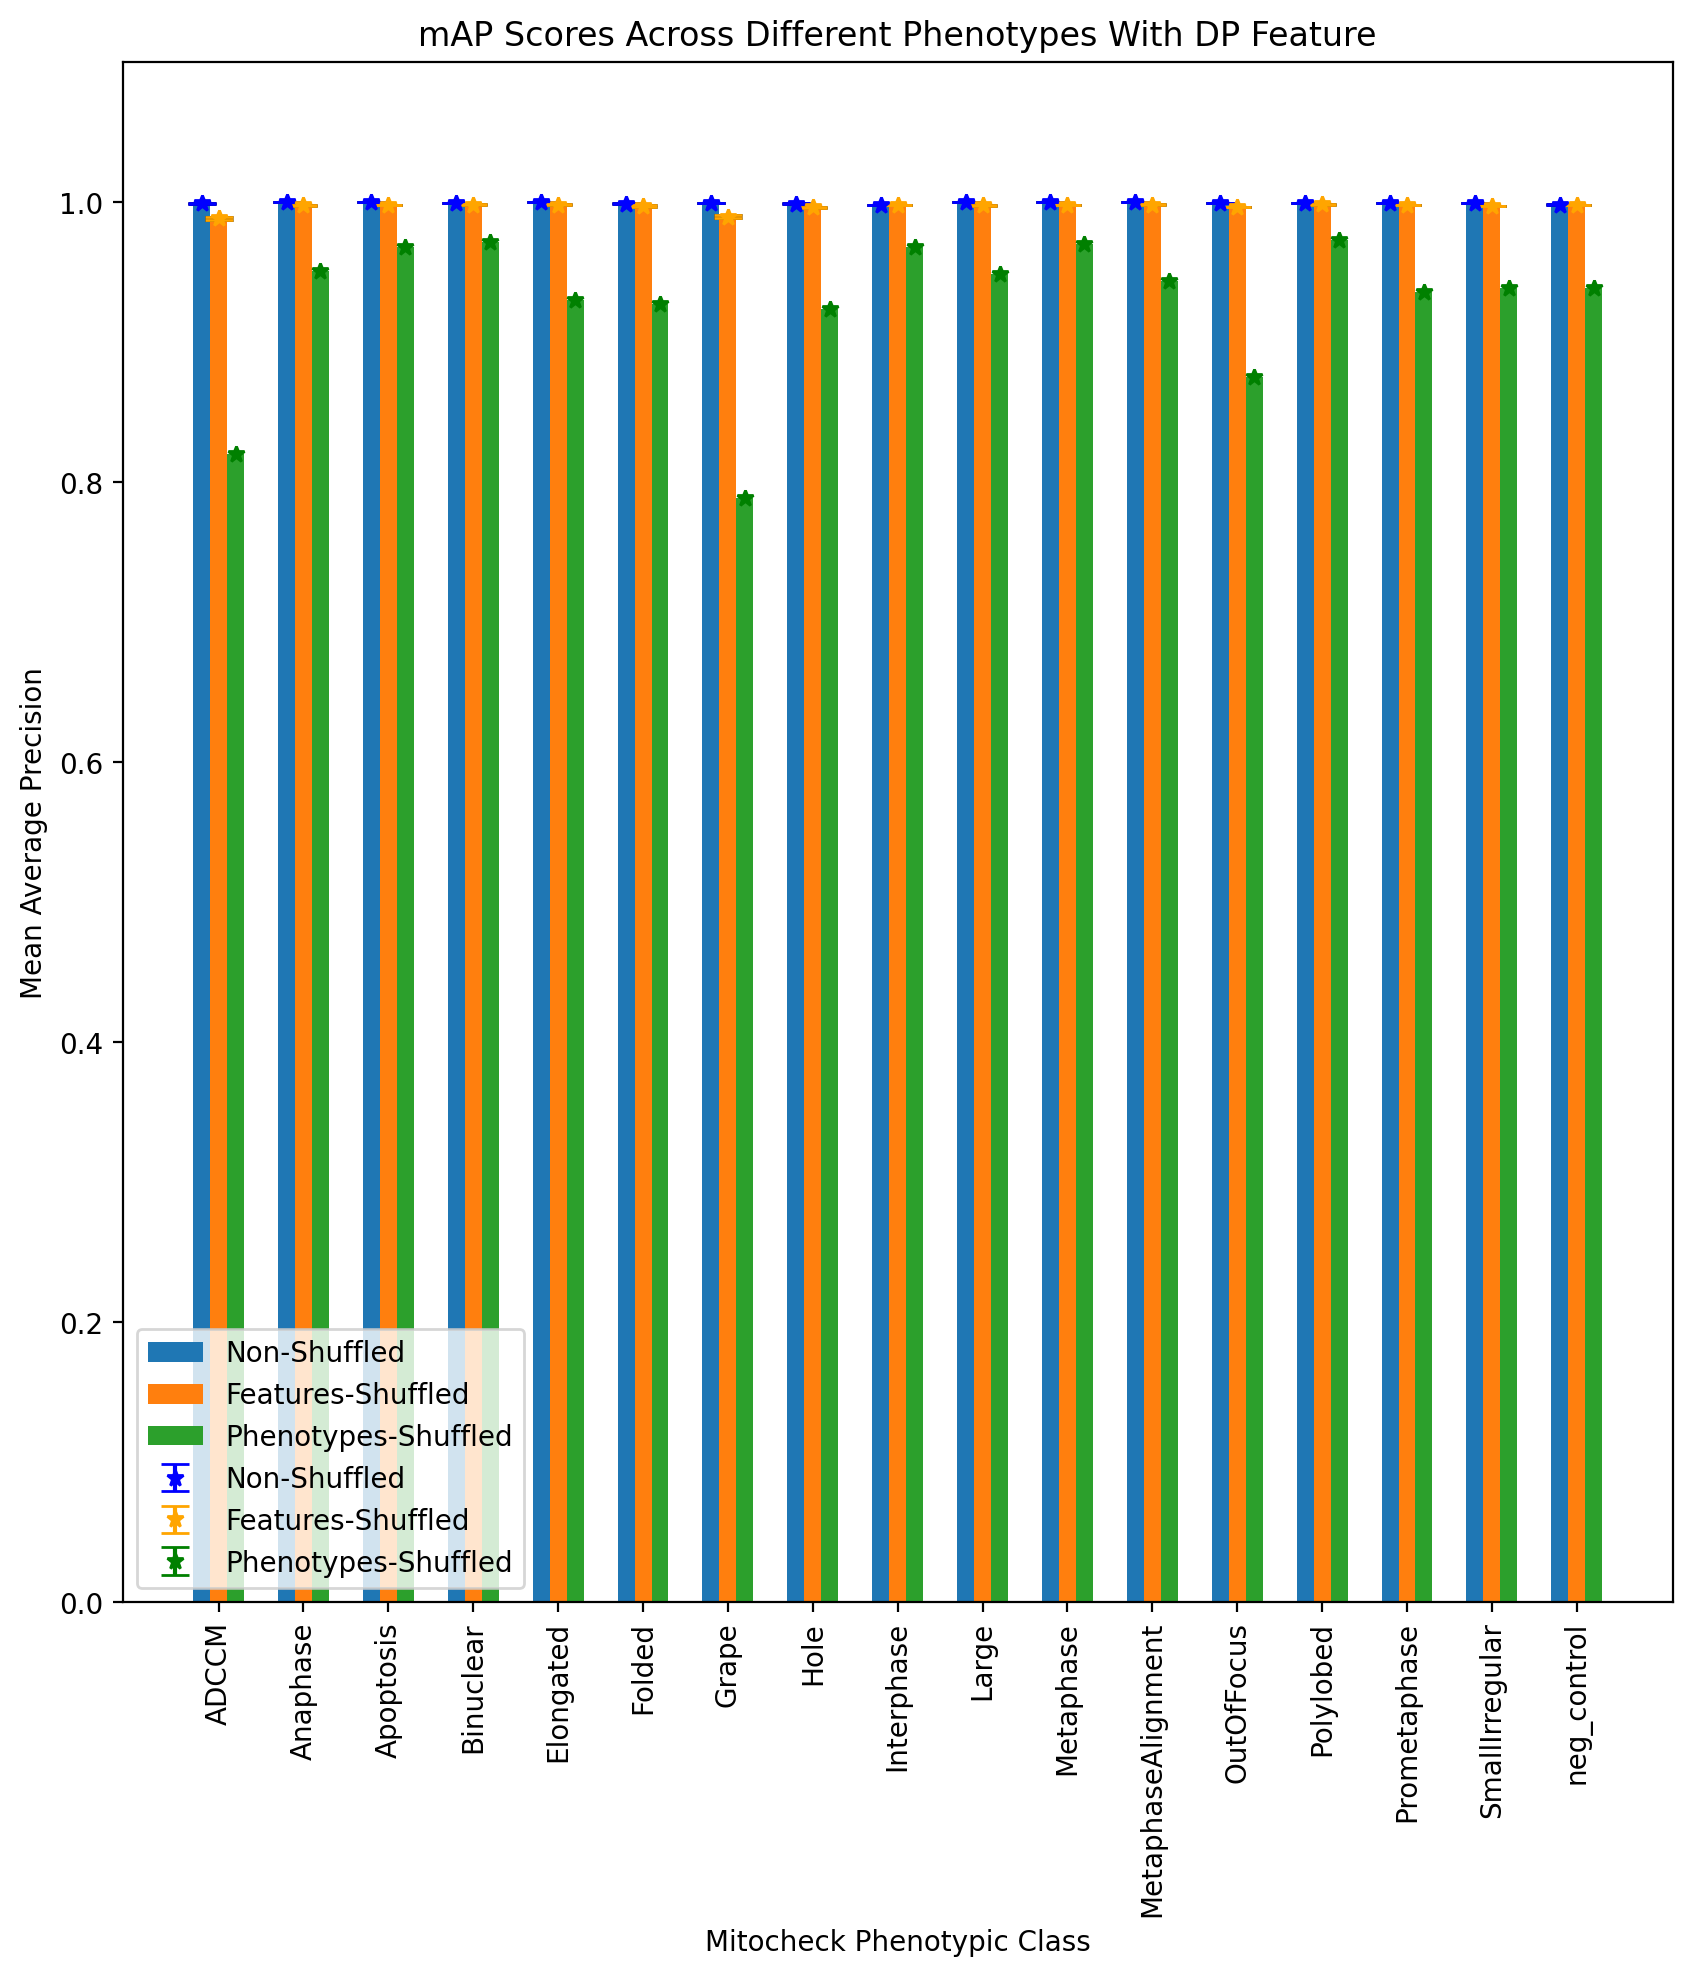

In [9]:
# figure size
plt.figure(figsize=(10, 10), dpi=200)

# phenotypes
data = (
    pd.concat(
        [
            agg_reg_dp_sc_mAPs,
            agg_shuffled_feat_dp_sc_mAPs,
            agg_shuffled_pheno_dp_sc_mAPs,
        ]
    )
    .reset_index()
    .drop("index", axis=1)
    .merge(
        sampling_error_df,
        on=["Mitocheck_Phenotypic_Class", "feature_type", "shuffled"],
        how="left",
    )
)

# creating bar plot
# groups: phenotype
# y-axis = mAP
df = data[
    [
        "Mitocheck_Phenotypic_Class",
        "mean_average_precision",
        "shuffled",
        "sampling_error",
    ]
]

# Pivot the DataFrame to have shuffled as columns
pivot_df = df.pivot_table(
    index="Mitocheck_Phenotypic_Class",
    columns="shuffled",
    values="mean_average_precision",
)

# Width of each bar
bar_width = 0.2

# Set positions for each group
positions = np.arange(len(pivot_df))

# Plot bars for each group
plt.bar(
    positions - bar_width,
    pivot_df["non-shuffled"],
    yerr=data[data["shuffled"] == "non-shuffled"]["sampling_error"],
    capsize=5,
    width=bar_width,
    label="Non-Shuffled",
)
plt.bar(
    positions,
    pivot_df["features_shuffled"],
    yerr=data[data["shuffled"] == "features_shuffled"]["sampling_error"],
    capsize=5,
    width=bar_width,
    label="Features-Shuffled",
)
plt.bar(
    positions + bar_width,
    pivot_df["phenotypes_shuffled"],
    yerr=data[data["shuffled"] == "phenotypes_shuffled"]["sampling_error"],
    capsize=5,
    width=bar_width,
    label="Phenotypes-Shuffled",
)
plt.errorbar(
    positions - bar_width,
    pivot_df["non-shuffled"],
    yerr=data[data["shuffled"] == "non-shuffled"]["sampling_error"],
    capsize=5,
    fmt="*",
    label="Non-Shuffled",
    color="blue",
)
plt.errorbar(
    positions,
    pivot_df["features_shuffled"],
    yerr=data[data["shuffled"] == "features_shuffled"]["sampling_error"],
    capsize=5,
    fmt="*",
    label="Features-Shuffled",
    color="orange",
)
plt.errorbar(
    positions + bar_width,
    pivot_df["phenotypes_shuffled"],
    yerr=data[data["shuffled"] == "phenotypes_shuffled"]["sampling_error"],
    capsize=5,
    fmt="*",
    label="Phenotypes-Shuffled",
    color="green",
)

# Additional plot customization
plt.xlabel("Mitocheck Phenotypic Class")
plt.ylabel("Mean Average Precision")
plt.ylim(0, 1.1)
plt.title("mAP Scores Across Different Phenotypes With DP Feature")
plt.xticks(positions, pivot_df.index, rotation=90)
plt.legend()

# Show the plot
plt.show()

### Barplot with CP_DP Features

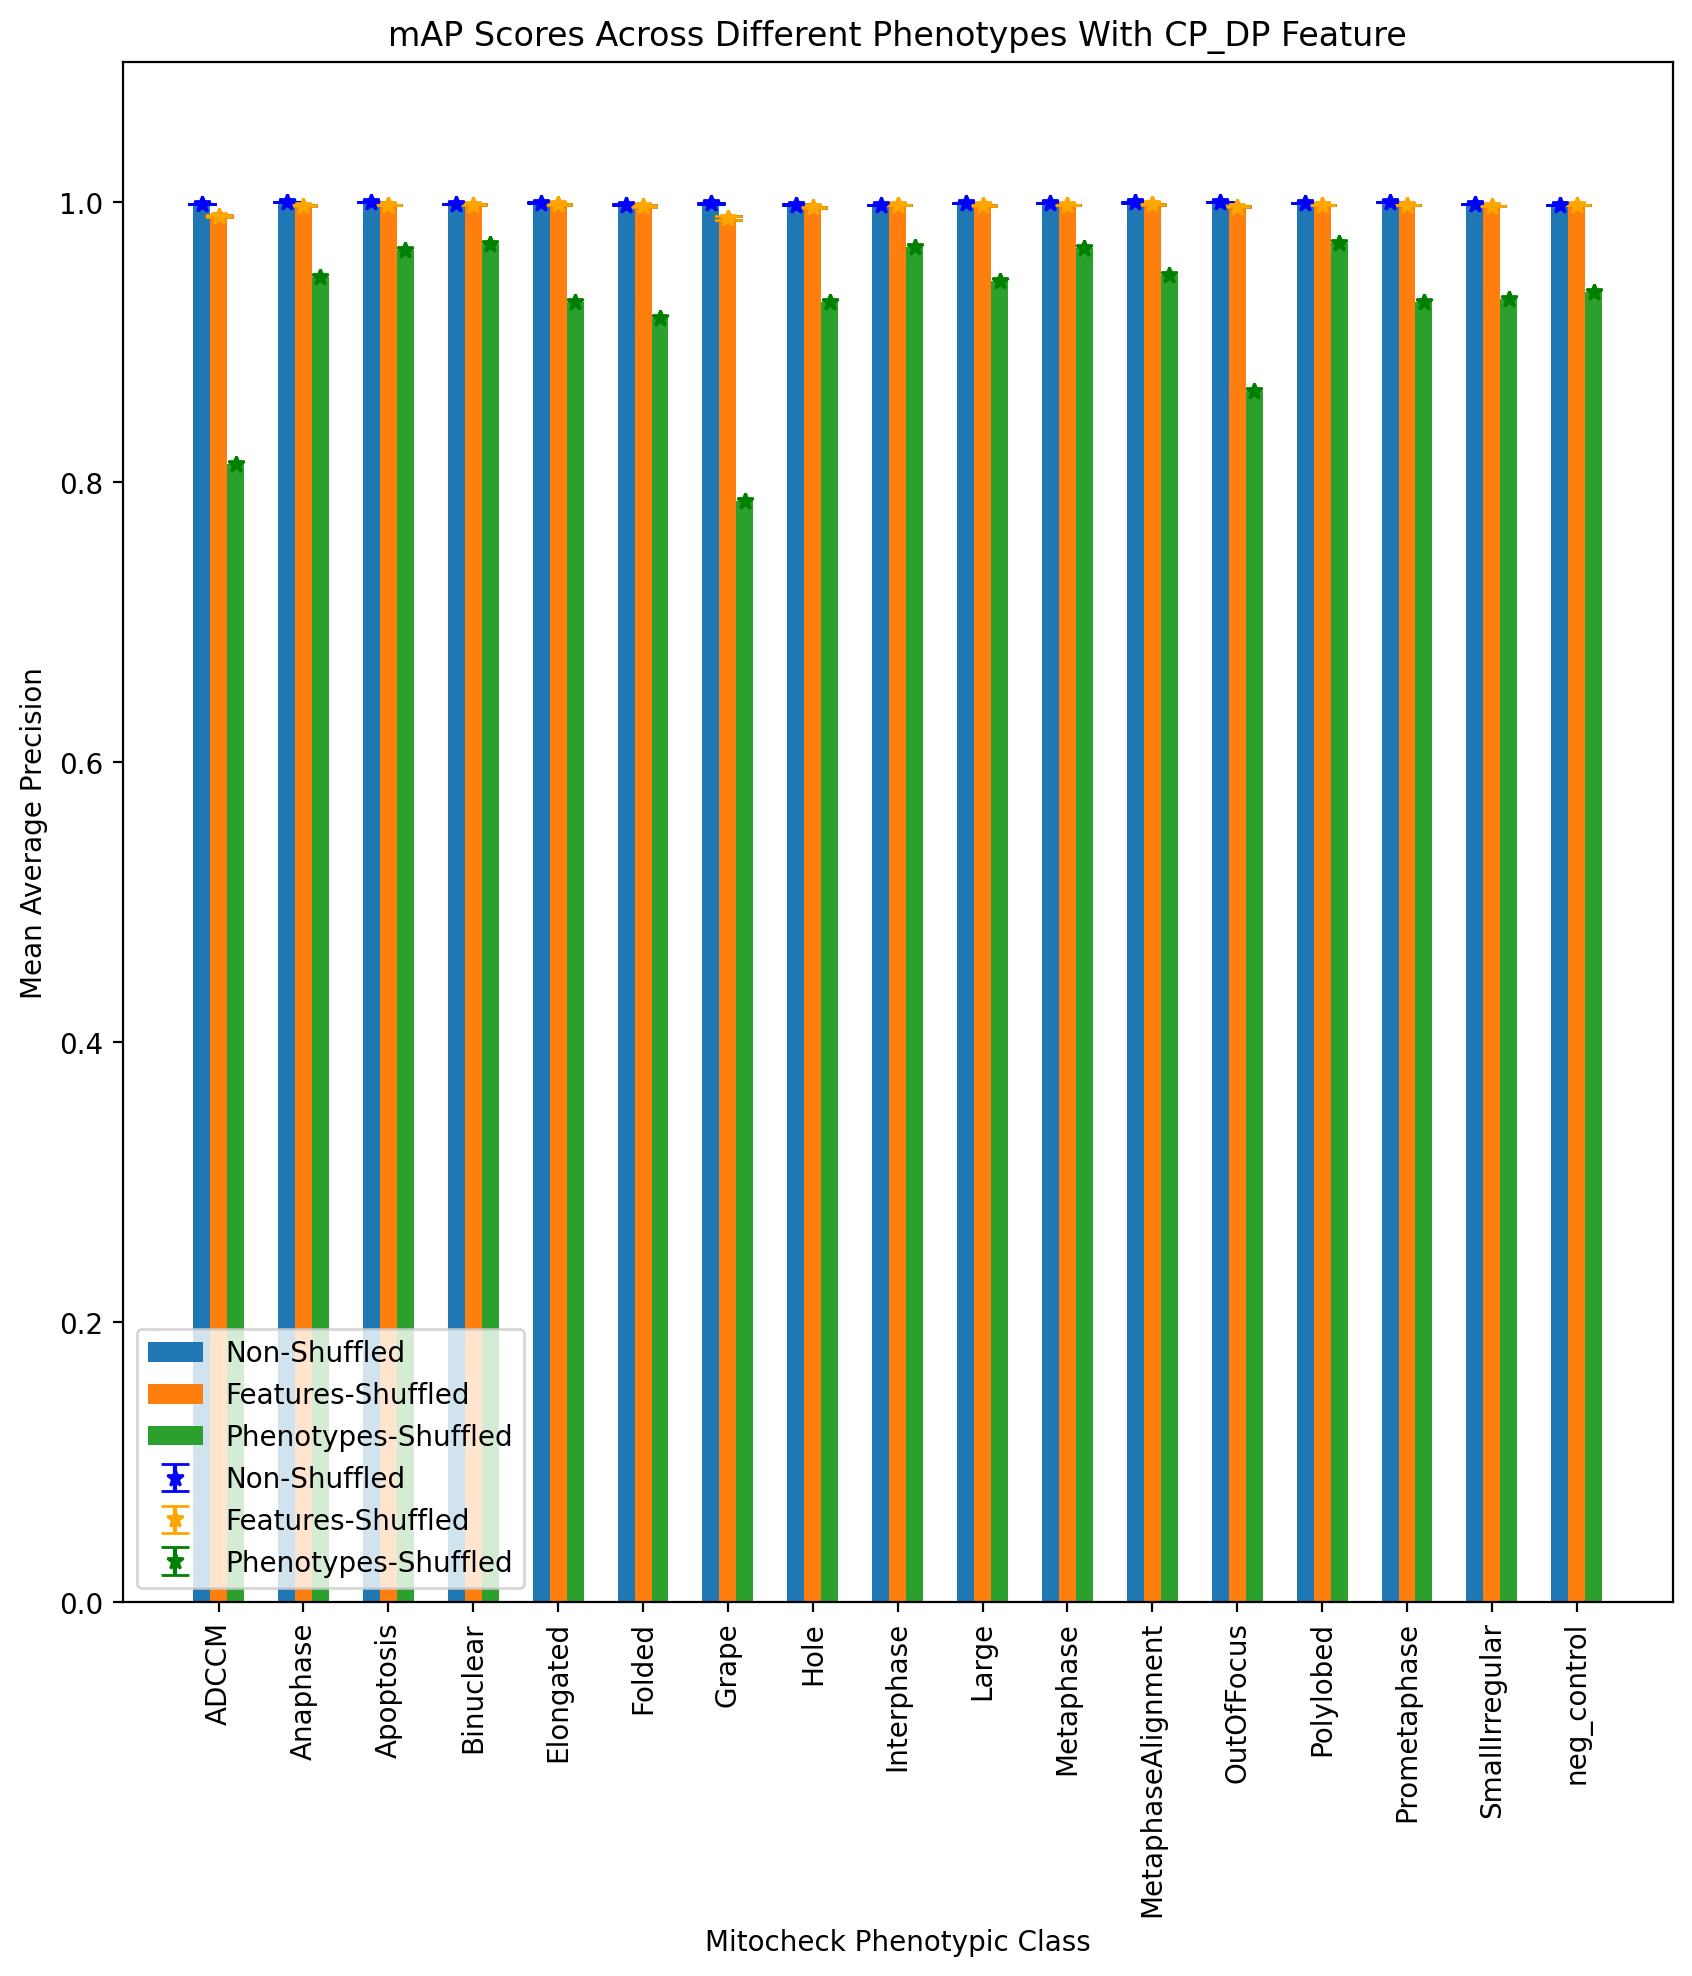

In [10]:
# figure size
plt.figure(figsize=(10, 10), dpi=200)

# phenotypes
data = (
    pd.concat(
        [
            agg_reg_cp_dp_sc_mAPs,
            agg_shuffled_feat_cp_dp_sc_mAPs,
            agg_shuffled_pheno_cp_dp_sc_mAPs,
        ]
    )
    .reset_index()
    .drop("index", axis=1)
    .merge(
        sampling_error_df,
        on=["Mitocheck_Phenotypic_Class", "feature_type", "shuffled"],
        how="left",
    )
)

# creating bar plot
# groups: phenotype
# y-axis = mAP
df = data[
    [
        "Mitocheck_Phenotypic_Class",
        "mean_average_precision",
        "shuffled",
        "sampling_error",
    ]
]

# Pivot the DataFrame to have shuffled as columns
pivot_df = df.pivot_table(
    index="Mitocheck_Phenotypic_Class",
    columns="shuffled",
    values="mean_average_precision",
)

# Width of each bar
bar_width = 0.2

# Set positions for each group
positions = np.arange(len(pivot_df))

# Plot bars for each group
plt.bar(
    positions - bar_width,
    pivot_df["non-shuffled"],
    yerr=data[data["shuffled"] == "non-shuffled"]["sampling_error"],
    capsize=5,
    width=bar_width,
    label="Non-Shuffled",
)
plt.bar(
    positions,
    pivot_df["features_shuffled"],
    yerr=data[data["shuffled"] == "features_shuffled"]["sampling_error"],
    capsize=5,
    width=bar_width,
    label="Features-Shuffled",
)
plt.bar(
    positions + bar_width,
    pivot_df["phenotypes_shuffled"],
    yerr=data[data["shuffled"] == "phenotypes_shuffled"]["sampling_error"],
    capsize=5,
    width=bar_width,
    label="Phenotypes-Shuffled",
)
plt.errorbar(
    positions - bar_width,
    pivot_df["non-shuffled"],
    yerr=data[data["shuffled"] == "non-shuffled"]["sampling_error"],
    capsize=5,
    fmt="*",
    label="Non-Shuffled",
    color="blue",
)
plt.errorbar(
    positions,
    pivot_df["features_shuffled"],
    yerr=data[data["shuffled"] == "features_shuffled"]["sampling_error"],
    capsize=5,
    fmt="*",
    label="Features-Shuffled",
    color="orange",
)
plt.errorbar(
    positions + bar_width,
    pivot_df["phenotypes_shuffled"],
    yerr=data[data["shuffled"] == "phenotypes_shuffled"]["sampling_error"],
    capsize=5,
    fmt="*",
    label="Phenotypes-Shuffled",
    color="green",
)

# Additional plot customization
plt.xlabel("Mitocheck Phenotypic Class")
plt.ylabel("Mean Average Precision")
plt.ylim(0, 1.1)
plt.title("mAP Scores Across Different Phenotypes With CP_DP Feature")
plt.xticks(positions, pivot_df.index, rotation=90)
plt.legend()

# Show the plot
plt.show()